In [ ]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi

Tue Apr  4 20:50:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import requests 
import py7zr

# Download and extract images

In [ ]:
# function for downloading the image files from a URL
def download_file(url, filename, chunk_size=128):
    response = requests.get(url, stream=True)
    with open(f'./{filename}', 'wb') as new_file:
        for chunk in response.iter_content(chunk_size=chunk_size):
            new_file.write(chunk)

In [ ]:
# define folders and filenames
dl_file_1 = 'rps.7z.001'
dl_file_2 = 'rps.7z.002'
filenames = [dl_file_1, dl_file_2]
output_file = 'rps.7z'
root_folder = './rps'
file_part1 = 'https://github.com/thetestspecimen/notebooks/raw/main/datasets/rock_paper_scissors/rock_paper_scissors_712.7z.001'
file_part2 = 'https://github.com/thetestspecimen/notebooks/raw/main/datasets/rock_paper_scissors/rock_paper_scissors_712.7z.002'

In [ ]:
# download files
download_file(url=file_part1, filename=dl_file_1)
download_file(url=file_part2, filename=dl_file_2)

In [ ]:
# concatenate files
with open(output_file, 'ab') as outfile: 
    for filename in filenames:
        with open(filename, 'rb') as infile:      
            outfile.write(infile.read())

# unzip concatenated file
with py7zr.SevenZipFile("rps.7z", "r") as archive:
    archive.extractall(path=root_folder)

# delete archives
for f in filenames:
    os.remove(f)
os.remove(output_file)

# Check extracted data

In [ ]:
# print files and folders
for root, dirs, files in os.walk(root_folder):
    print(f"{len(dirs)} directories and {len(files)} files in '{root}'")

3 directories and 0 files in './rps'
0 directories and 712 files in './rps/scissors'
0 directories and 712 files in './rps/rock'
0 directories and 712 files in './rps/paper'


# Plot an example from each class

In [ ]:
# View an image
import matplotlib.image as mpimg
import random

def plot_example_image(target_class):
  
  # target directory
  target_folder = f'rps/{target_class}'

  # random image
  random_image = random.sample(os.listdir(target_folder), 1)

  # plot image
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(f"Class: {target_class}")
  plt.axis("off")

  print(f"Type: {type(img)}")
  print(f"Shape: {img.shape}")
  print(f"Colour channels: {img.shape[2]}")
  print(f"Size: {img.size / 1000}KB")
  print(f"Max value: {img.max()}")
  print(f"Min value: {img.min()}")
  print(f"Image name: {random_image[0]}")

  return img

Type: <class 'numpy.ndarray'>
Shape: (200, 300, 3)
Colour channels: 3
Size: 180.0KB
Max value: 0.9450980424880981
Min value: 0.0
Image name: yoses2FRtQruYUYE.png


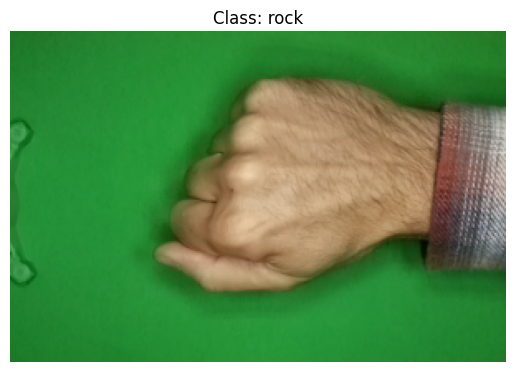

In [ ]:
img = plot_example_image("rock"); 

Type: <class 'numpy.ndarray'>
Shape: (200, 300, 3)
Colour channels: 3
Size: 180.0KB
Max value: 0.8588235378265381
Min value: 0.0
Image name: BH9zAUdmmjlfXwtS.png


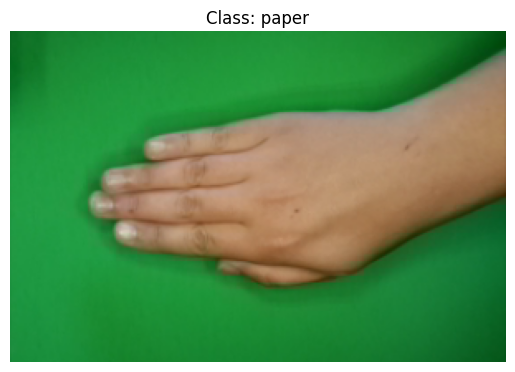

In [ ]:
img = plot_example_image("paper"); 

Type: <class 'numpy.ndarray'>
Shape: (200, 300, 3)
Colour channels: 3
Size: 180.0KB
Max value: 0.8352941274642944
Min value: 0.0235294122248888
Image name: UPH9bl4Vrq4Gwp3K.png


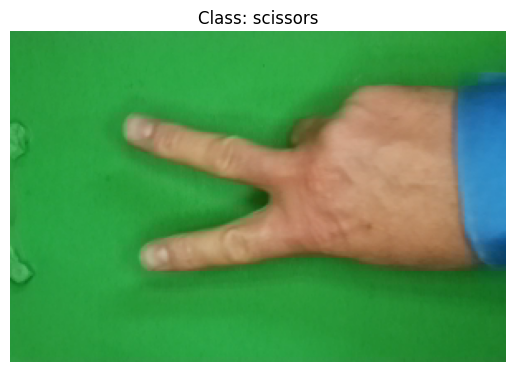

In [ ]:
img = plot_example_image("scissors"); 

# Prepare data

In [ ]:
# Constants
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)
BATCH_SIZE = 128
DATA_DIR = f"{root_folder}/"
SEED = 12

In [ ]:
train_data, val_data = tf.keras.utils.image_dataset_from_directory(DATA_DIR, 
                                                                   labels='inferred',
                                                                   label_mode='categorical',
                                                                   batch_size=BATCH_SIZE,
                                                                   image_size=IMAGE_SIZE,
                                                                   shuffle=True, 
                                                                   seed=SEED,
                                                                   validation_split=0.2,
                                                                   subset='both')                        

Found 2136 files belonging to 3 classes.
Using 1709 files for training.
Using 427 files for validation.


In [ ]:
# get the class names generated from the dataset
class_names = train_data.class_names
num_classes = len(class_names)
class_names

['paper', 'rock', 'scissors']

# Plot Example data from all classes

In [ ]:
# THIS PLOT ONLY WORKS IF THE BATCH SIZE IS LARGE ENOUGH TO
# CONTAIN 3 EXAMPLES FROM EACH CLASS

# plt.figure(figsize=(10, 10))
# for images, labels in train_data.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[tf.math.argmax(labels[i])])
#     plt.axis("off")

# Data augmentation

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# augment the image files
# the image files are PNG, and therefore already sit beween 0 and 1.
# typically a rescaling layer would be required if they were JPG
# however EfficientNet has an inbuilt scaling layer so even then it isn't required

data_augmentation = Sequential([
                                layers.RandomRotation(0.2),
                                layers.RandomFlip('horizontal'),
                                layers.RandomZoom(0.2)
], name='data_augmentation')

# Configure Datasets

In [ ]:
train_data, val_data

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>)

In [ ]:
# THESE LINES ARE A VALID OPTIMISATION
# HOWEVER IT REQUIRES SUFFICIENT SYSTEM RAM (NOT GPU RAM) TO RUN SUCCESSFULLY

# train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, val_data

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>)

# Create Model

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet")
base_model.trainable = True
inputs = layers.Input(shape=(IMAGE_SIZE + (3,)), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(units=num_classes, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 4,011,391
Non-train

# Compile and Fit Model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data,
                    verbose=1)

Epoch 1/10
14/14 [==============================] - 67s 1s/step - loss: 0.1854 - accuracy: 0.9251 - val_loss: 0.0269 - val_accuracy: 0.9953
Epoch 2/10
14/14 [==============================] - 17s 1s/step - loss: 0.0133 - accuracy: 0.9965 - val_loss: 0.0377 - val_accuracy: 0.9977
Epoch 3/10
14/14 [==============================] - 18s 1s/step - loss: 0.0440 - accuracy: 0.9877 - val_loss: 0.1214 - val_accuracy: 0.9766
Epoch 4/10
14/14 [==============================] - 17s 1s/step - loss: 0.0199 - accuracy: 0.9947 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 5/10
14/14 [==============================] - 17s 1s/step - loss: 0.0127 - accuracy: 0.9965 - val_loss: 3.9465e-06 - val_accuracy: 1.0000
Epoch 6/10
14/14 [==============================] - 18s 1s/step - loss: 0.0072 - accuracy: 0.9994 - val_loss: 5.6489e-05 - val_accuracy: 1.0000
Epoch 7/10
14/14 [==============================] - 17s 1s/step - loss: 0.0031 - accuracy: 0.9988 - val_loss: 0.0048 - val_accuracy: 0.9977
Epoch 8/10
1

# Peak GPU memory usage during the run

In [ ]:
# print the peak GPU usage in GB for each GPU
for i, gpu in enumerate(tf.config.list_physical_devices('GPU')):
  # Returns a dict in the form {'current': <current mem usage>,
  #                             'peak': <peak mem usage>}
    mem_usage = tf.config.experimental.get_memory_info(f'GPU:{i}').get('peak')/1e9
    print(f'GPU Peak Memory Usage: {mem_usage:.2f}GB')

GPU Peak Memory Usage: 13.17GB
